# Experimental Holography

`slmsuite` targets _experimental_ holography on physical hardware.
In this example, we show how to connect to a camera and an SLM and
calibrate the transformation between the camera's space and the SLM's $k$-space.

The setup running this notebook (and the notebooks for other examples) is very simple.
From the left in the below diagram, we have an input laser which is expanded to the size of the SLM.
This light reflects from the SLM, exits the alternate port of a 50:50 beamsplitter, and
reaches the camera. Importantly, a lens is positioned inbetween the camera and SLM with
a distance corresponding to the focal length $f$ from each. Thus, the camera's imaging plane is the
farfield of the SLM (also called Fourier domain or $k$-space of the SLM).

![Setup diagram](https://raw.githubusercontent.com/QPG-MIT/slmsuite-examples/main/examples/setup_diagram.png)

<!-- <p style="text-align: center">
    <img src="setup_diagram.png" width="600" style="display=block; margin:auto"/>
</p>
<p style="text-align: center">
    <i>A diagram of the SLM setup used for these examples.</i>
</p> -->

In [2]:
# Header.

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time
import numpy as np
import cv2
import scipy.ndimage as ndimage

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from slmsuite.holography import analysis, toolbox
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.holography.algorithms import FeedbackHologram, SpotHologram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Loading Hardware

**Cameras** and **SLMs** are connected to python by a myriad of SDKs, often provided by hardware
vendors. However, these SDKs likewise have a myriad of function names and hardware-specific
quirks. Thus, hardware in `slmsuite` is integrated as subclasses of
the abstract classes `.Camera` and `.SLM`.
These subclasses for [cameras](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.html) 
and [slms](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.html)
are effectively wrappers for given SDKs, implemented with standardized methods and syntax that the rest of `slmsuite` can understand, but also include
quality-of-life features.
If you believe your camera or SLM is not supported by the currently available classes, please 
[open a GitHub issue](https://github.com/QPG-MIT/slmsuite/issues) 
or [feel free to write an interface yourself](https://github.com/QPG-MIT/slmsuite/blob/main/CONTRIBUTING.md)!

First, let's load an SLM. We're running this notebook with a `Santec` SLM.
We can find connected displays with the `.info()` static method.

In [3]:
from slmsuite.hardware.slms.santec import Santec
Santec.info(verbose=True);

Displays detected by Santec
display_number, display_name:
1,  HP S2231,HWP,2905,3CQ02001CN
2,  LCOS-SLM,SOC,8001,2018021001


We see that `display_number=2` is the display with the LCoS SLM. We're running this setup with a 633 nm HeNe laser. All functions are documented, including the below 
[initializer](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.santec.Santec.html#slmsuite.hardware.slms.santec.Santec.__init__).

In [4]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.3)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success


Next, let's load a camera. We're running this notebook with a `AlliedVision` camera. We can find connected cameras with the `.info()` static method.

In [5]:
from slmsuite.hardware.cameras.alliedvision import AlliedVision
AlliedVision.info(verbose=True);

AlliedVision serials:
"02C5V"
"08-406808001844"


We want the `"02C5V"` serial.

In [6]:
cam = AlliedVision(serial="02C5V", verbose=True)

vimba initializing... success
Looking for cameras... success
vimba sn 02C5V initializing... success


Lastly, we'll make a [class for our composite optical system](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM), 
consisting of the camera and the SLM. We'll also load a previously-measured 
[wavefront calibration](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM.wavefront_calibrate)
(we'll come back to this in a later example!).

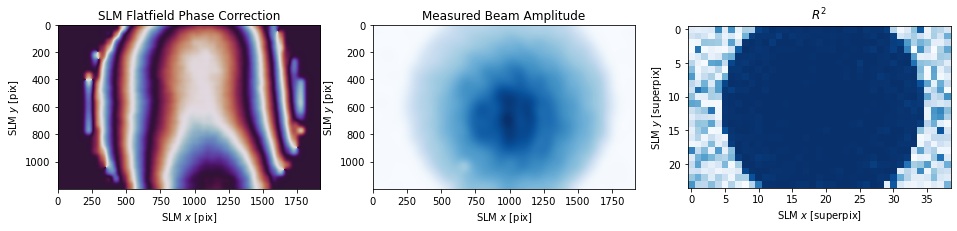

In [7]:
from slmsuite.hardware.cameraslms import FourierSLM
fs = FourierSLM(cam, slm)
fs.load_wavefront_calibration(plot=True);    # We'll come back to this!

#### Simple Holography

Let's start out with the simplest phase pattern possible: no pattern! We 
[write](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.slm.SLM.html#slmsuite.hardware.slms.slm.SLM.write) 
a flat phase $\phi(\vec{x}) = 0\pi$ to the SLM with `.write()`.

In [8]:
phase = np.zeros(slm.shape)
slm.write(phase, settle=True);      # slm.write(None, settle=True) is equivalent to this.

Great. Let's [take a look](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.camera.Camera.html#slmsuite.hardware.cameras.camera.Camera.get_image)
at the result in our camera with `.get_image()`. We'll also set the exposure to an appropriate value.

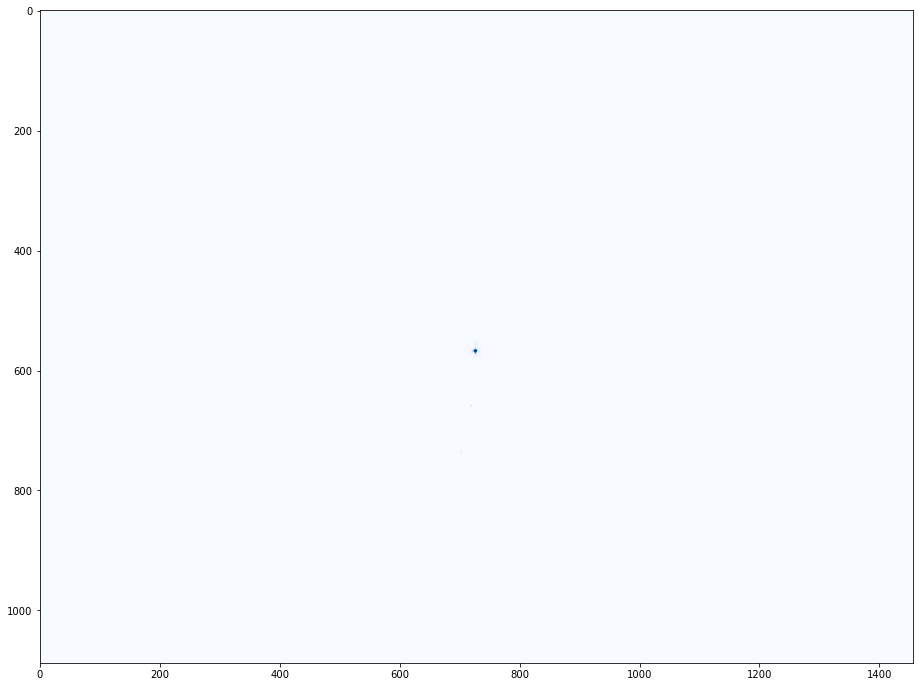

In [9]:
cam.set_exposure(.0002)
img = cam.get_image()

# Plot the result
plt.figure(figsize=(24, 12))
plt.imshow(img)
plt.show()

As expected, we see a spot corresponding to the zero-th order diffraction peak. This spot is focussed at the center of our camera.

We're going to be `.write()`ing phases and `.get`ing`_image()`s a couple more times in this notebook, so we'll define a method `plot_phase()` to help us with that.

In [10]:
def plot_phase(phase, title="", zoom=True):
    # One plot if no camera; two otherwise.
    _, axs = plt.subplots(1, 2 - (cam is None), figsize=(24,6))

    if cam is None:
        axs = [axs]
    
    # Plot the phase.
    axs[0].set_title("SLM Phase")
    im = axs[0].imshow(
        np.mod(phase, 2*np.pi), 
        vmin=0,
        vmax=2*np.pi, 
        interpolation="none", 
        cmap="twilight"
    )
    plt.colorbar(im, ax=axs[0])
    
    # Grab an image of the resulting pattern and plot.
    slm.write(phase, settle=True)
    img = cam.get_image()

    axs[1].set_title("Camera Result")
    axs[1].imshow(img)
    if zoom:
        xlim = axs[1].get_xlim()
        ylim = axs[1].get_ylim()
        axs[1].set_xlim([xlim[0] * .7 + xlim[1] * .3, xlim[0] * .3 + xlim[1] * .7])
        axs[1].set_ylim([ylim[0] * .7 + ylim[1] * .3, ylim[0] * .3 + ylim[1] * .7])

    # Make a title, if given.
    plt.suptitle(title)
    plt.show()

Next, we'll move the laser spot by applying a 
[blazed grating](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.blaze.html#slmsuite.holography.toolbox.blaze)
to the SLM using a helper function from our `toolbox`. This blazed grating has a Fourier spectrum shifted from the origin, so naturally applying this pattern to the SLM will produce a shifted result in the farfield, i.e. in the plane of the camera.

Many common phases patterns are available in the `slmsuite.holography.toolbox`. See the Structured Light example for more information (e.g. the behavior of `grid=`).

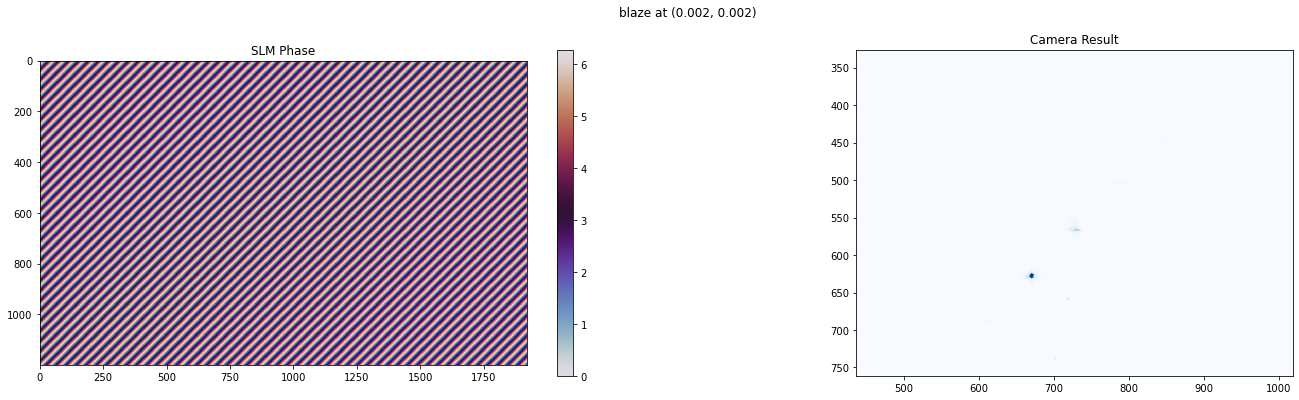

In [11]:
from slmsuite.holography import toolbox

vector = (.002, .002)   # Radians (== normalized units kx/k)
blaze_phase = toolbox.blaze(grid=slm, vector=vector)
plot_phase(blaze_phase, title="blaze at {}".format(vector))

But what units does `vector` have? The default blaze units in `slmsuite` (`"norm"`) are normalized $k_x/k$ units, which are equivalent to radians in the small angle approximation. To get a better handle on what `vector = (.002, .002)` means, we can 
[print](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.print_blaze_conversions.html#slmsuite.holography.toolbox.print_blaze_conversions)
the equivalent vectors converted to supported units with `toolbox.print_blaze_conversions()`.

In [12]:
toolbox.print_blaze_conversions(vector=(.002, .002), from_units="norm", slm=slm)

'norm' : (0.002, 0.002)
'kxy' : (0.002, 0.002)
'rad' : (0.002, 0.002)
'knm' : (1008.5308056872038, 630.3317535545024)
'freq' : (0.02527646129541864, 0.02527646129541864)
'lpmm' : (3.1595576619273302, 3.1595576619273302)
'mrad' : (2.0, 2.0)
'deg' : (0.11459155902616464, 0.11459155902616464)


Okay. So this means that we're diffracting light by an angle of two miliradians or a tenth of a degree.
Of course, all the units are [documented](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.convert_blaze_vector.html#slmsuite.holography.toolbox.convert_blaze_vector).

This function wraps `toolbox.convert_blaze_vector()` which handles arbitrary unit conversions. Let's try it out by diffracting light at .2 degrees in the $x$ and $y$ directions.

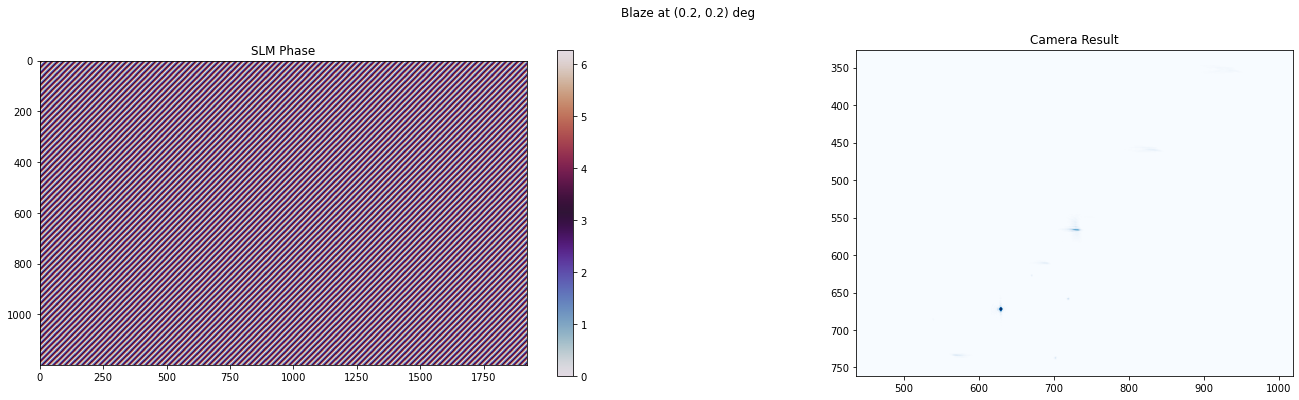

In [13]:
vector_deg = (.2, .2)
vector = toolbox.convert_blaze_vector(vector_deg, from_units="deg", to_units="norm")
blaze_phase = toolbox.blaze(grid=slm, vector=vector)
plot_phase(blaze_phase, title="Blaze at {} deg".format(vector_deg))

All this is good fun, but let's say we wanted our spot right at pixel `(600, 600)`. We could iterate by guessing and checking successive `vectors`, but that seems boring and non-pythonic. Instead, we will calibrate a transformation between the $k$-space of the SLM and the space of the camera using features built-in to `slmsuite`.

#### Fourier Calibration

Calibration is simple, just run a built-in function `.fourier_calibrate()` to 1) generate and 2) fit a grid of spots (with known $k$-space coordinates) with an affine transformation to the space of the camera. This grid is generated using 
[techniques](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.algorithms.html)
that we'll discuss later. Care must be taken to choose:

 - A camera exposure such that spots are prominent,
 - A pitch and shape of the array which are visible.

Note that the default array units are in `"knm"` space, or the 
[computational space of holography](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.algorithms.html). 
Read more about this in later examples.

100%|██████████| 50/50 [00:00<00:00, 87.34it/s] 


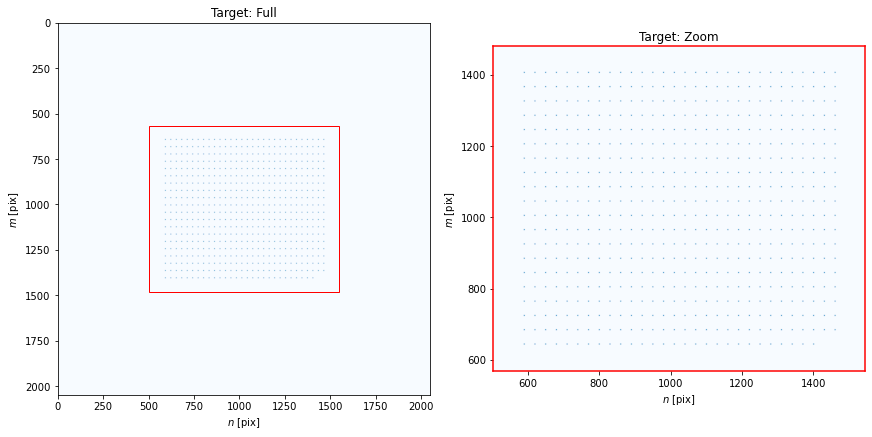

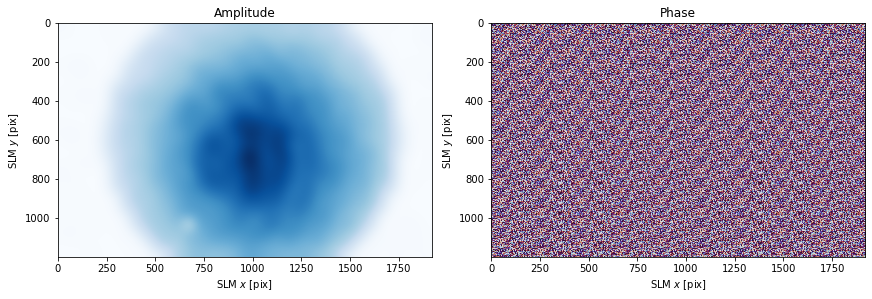

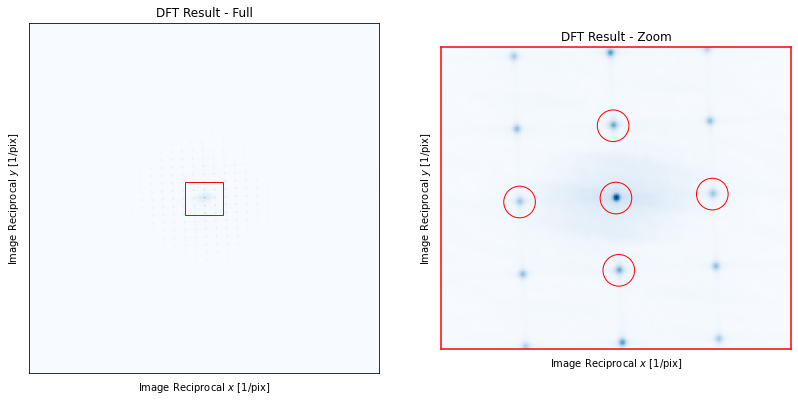

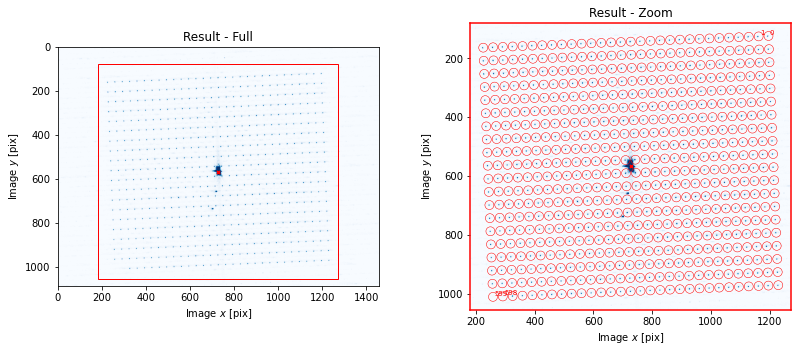

{'M': array([[-28876.09736229,   1132.92238856],
        [  1181.73152374,  28874.45488851]]),
 'b': array([[726.80342304],
        [567.34497028]]),
 'a': array([[-5.42702563e-05],
        [-4.91016605e-05]])}

In [128]:
cam.set_exposure(.05)               # Increase exposure because power will be split many ways

fs.fourier_calibrate(
    array_shape=[30, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[30, 40],           # Pitch of the calibration grid (x, y) [knm]
    plot=True
)

Notice that there are two missing spots from the array. This is a parity check to make sure the calibration is flipped in the correct direction.

The result of this process is the transformation

$\vec{x} = M \cdot (\vec{k} - \vec{a}) + \vec{b}$

where $\vec{x}$ is in units of camera pixels and $\vec{k}$ is in units of normalized $k$-space. We can view the result in the `fourier_calibration` variable.

In [15]:
fs.fourier_calibration

{'M': array([[-28858.92681294,   1132.92238856],
        [  1180.32420503,  28874.45488851]]),
 'b': array([[726.73859929],
        [567.41907558]]),
 'a': array([[-5.42702563e-05],
        [-4.91016605e-05]])}

Now let's use this calibration to achieve our goal of `(600, 600)`. We can find the blaze vector $\vec{k}$ (in normalized units) corresponding to the desired pixel $\vec{x}$ using our calibration.

In [16]:
vector_600_600 = fs.ijcam_to_kxyslm((600, 600))
print(vector_600_600)

[[0.00437458]
 [0.00089822]]


Now let's check this result:

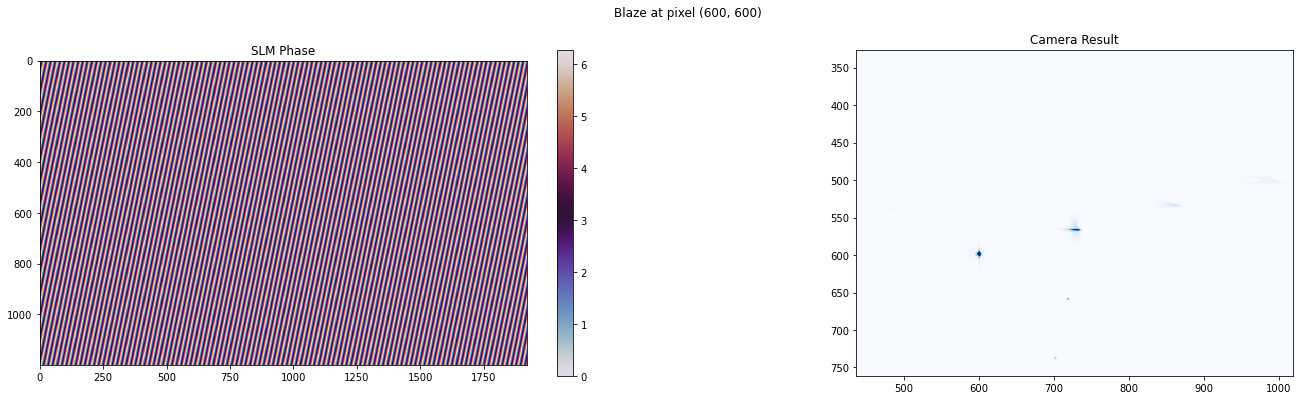

In [17]:
cam.set_exposure(.0005)
blaze_phase = toolbox.blaze(grid=slm, vector=vector_600_600)
plot_phase(blaze_phase, title="Blaze at pixel (600, 600)")

### Spot Holography

The previous examples considered blazing light in one direction towards one point, but what if we want to generate patterns with many spots? Of course, this isn't as simple as adding the blaze patterns for $\vec{k}_1$ and $\vec{k}_2$, as this would just blaze light along $\vec{k} = \vec{k}_1 + \vec{k}_2$. Things are more complicated. This example will show how to generate `SpotHologram`s with `slmsuite`.



#### A Square Array and `take`

Let's consider a case where we want to fill part of our camera's space with a square array of spots, spaced with a pitch of 100 pixels.

[ 100  200  300  400  500  600  700  800  900 1000]


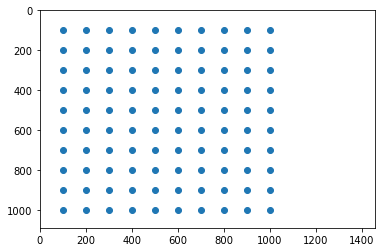

In [18]:
xlist = np.arange(100, min(fs.cam.shape), 100)                      # Get the coordinates for one edge
print(xlist)

xgrid, ygrid = np.meshgrid(xlist, xlist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))                  # Make an array of points in a grid

plt.scatter(square[0,:], square[1,:])                               # Plot the points
plt.xlim([0, fs.cam.shape[1]]); plt.ylim([fs.cam.shape[0], 0])
plt.show()

Making a hologram is simple. we initialize a hologram with a computational space of shape `(2048, 2048)`. This shape just has to be larger than the SLM shape, and should ideally consist of powers of two. We provide the points in the `"ij"` basis of our camera's pixels, made possible by the Fourier calibration passed via our `FourierSLM` named `fs`.

In [19]:
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=square, basis='ij', cameraslm=fs)

This initialize just constructs datastructures, but does not conduct optimization.

We can first plot the target amplitudes at desired locations in the `"knm"` basis, which is needed to apply discrete Fourier transforms. Our Fourier calibration also shows us how our camera's field of view (in yellow) compares to the size of the computational space.

Next, we plot the amplitudes resulting from the initial conditions of optimization (random phase). This just looks like noise, as expected.

[[800, 1200], [800, 1200]]


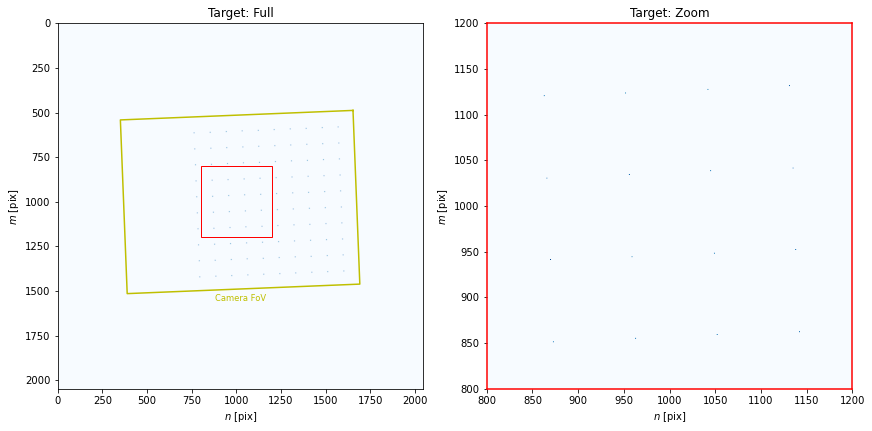

[[800, 1200], [800, 1200]]


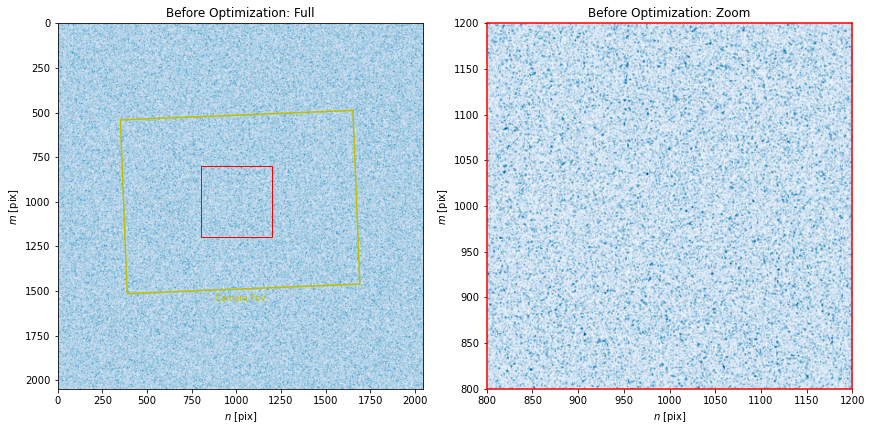

In [20]:
hologram.plot_farfield(hologram.target,                     limits=[[800, 1200], [800, 1200]], title="Target");
hologram.plot_farfield(np.abs(hologram.extract_farfield()), limits=[[800, 1200], [800, 1200]], title="Before Optimization");

This randomness won't last. We quickly take 50 iterations of optimization towards our target. Here, we use weighted [Gerchberg-Saxton](https://en.wikipedia.org/wiki/Gerchberg%E2%80%93Saxton_algorithm)-type algorithms to iteratively hone the nearfield phase pattern to produce the desired farfield at the camera. 

100%|██████████| 50/50 [00:01<00:00, 49.02it/s]


[[800, 1200], [800, 1200]]


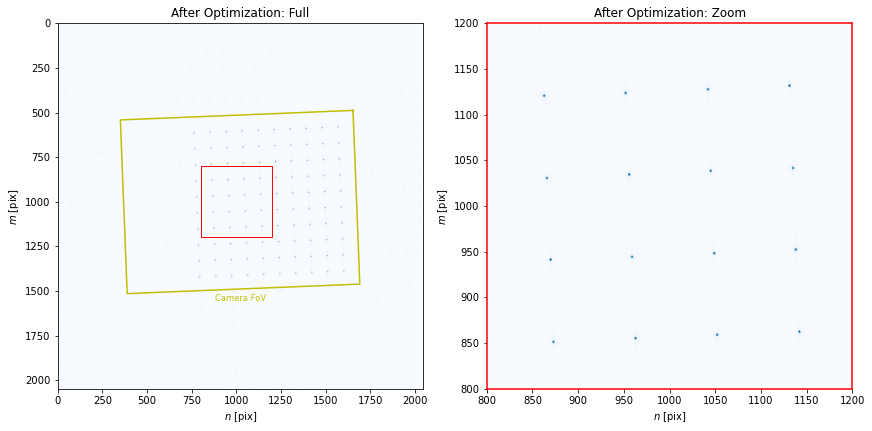

In [21]:
hologram.optimize('WGS-Kim', feedback='computational', stat_groups=['computational'], maxiter=50)
hologram.plot_farfield(np.abs(hologram.extract_farfield()), limits=[[800, 1200], [800, 1200]], title="After Optimization");

Now the computed result of our optimized hologram roughly matches the target. The phase that generates this amplitude result in the farfield is plotted below. The amplitude pattern is an estimate of the real nearfield amplitude measured via wavefront calibration. Note that we plot both the system padded to the `(2048, 2048)` shape of the computational space (used during optimization) and the system cropped to the shape of the SLM (used in practice).

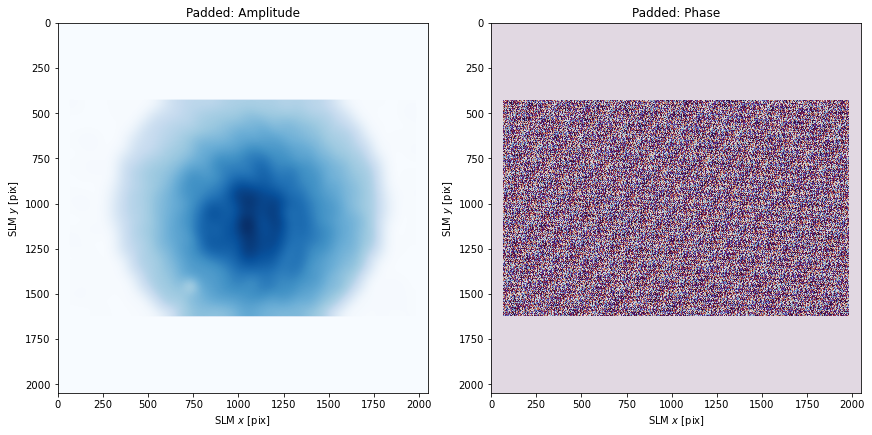

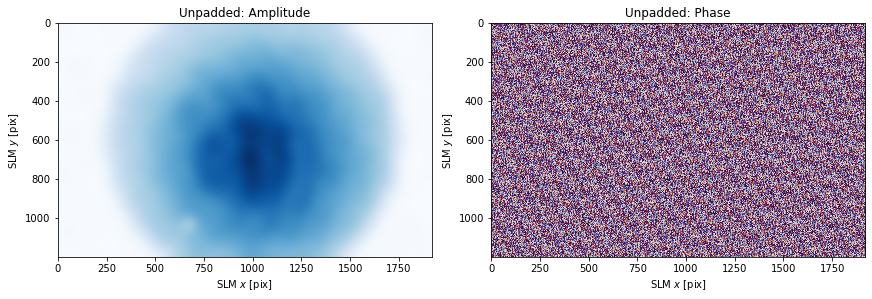

In [22]:
hologram.plot_nearfield(title="Padded", padded=True)
hologram.plot_nearfield(title="Unpadded")

Let's see how this looks experimentally.

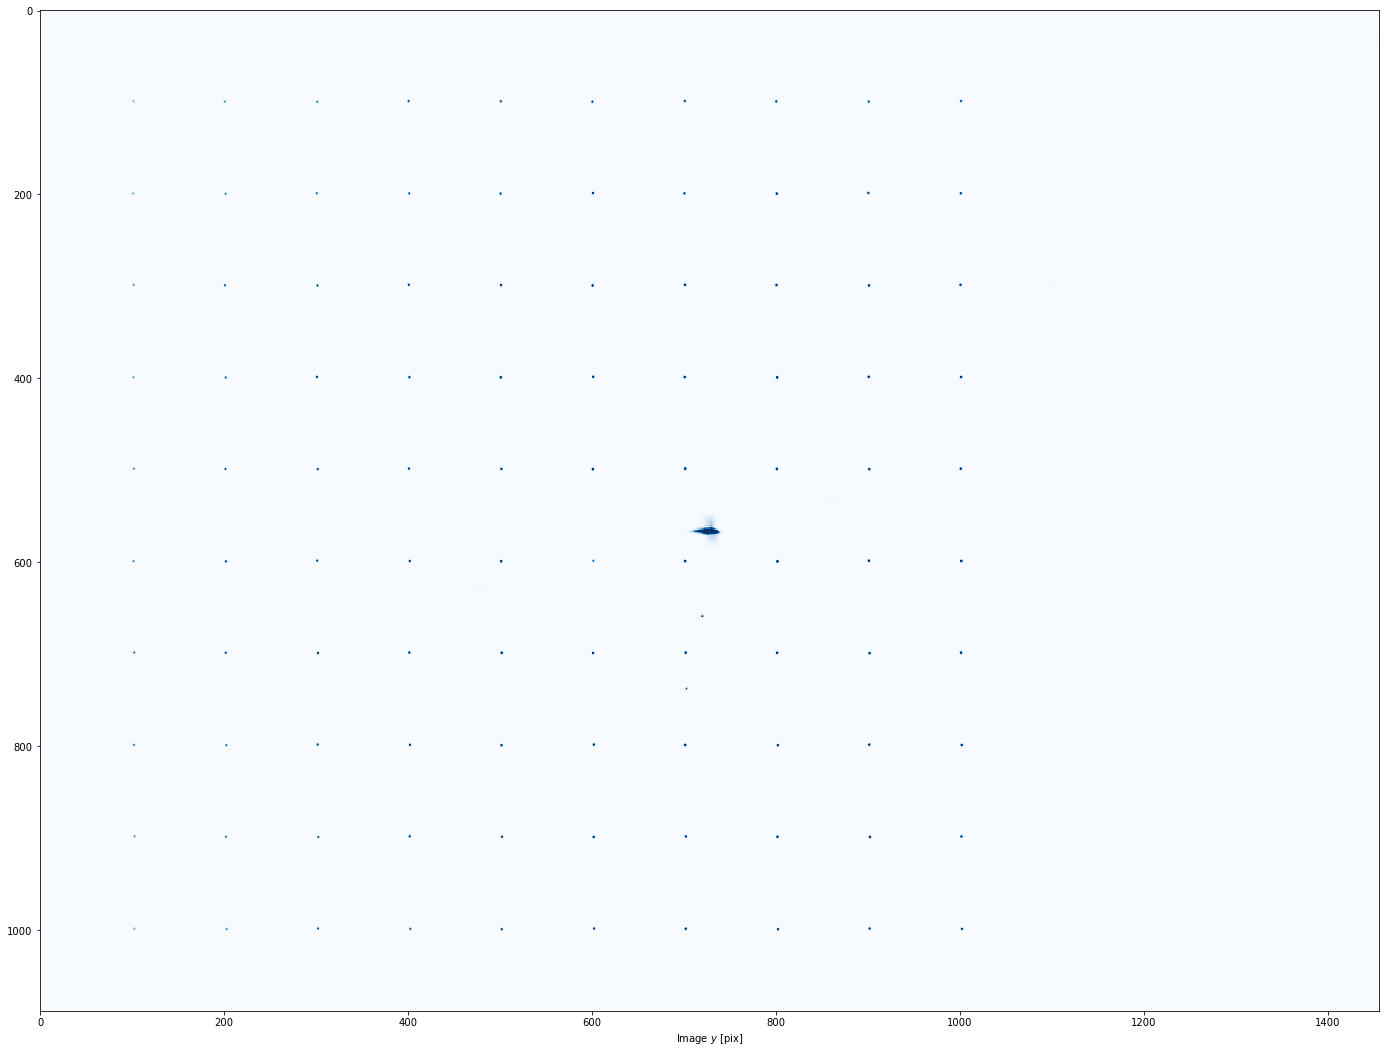

In [23]:
fs.slm.write(hologram.extract_phase(), settle=True)             # Write hologram.
cam.set_exposure(.0002)
img = fs.cam.get_image()                                        # Grab image.

plt.figure(figsize=(24,24));    plt.imshow(img, vmax=50)        # This is saturated for visibility.
plt.xlabel("Image $x$ [pix]");  plt.xlabel("Image $y$ [pix]")
plt.show()

Looks good! Those two extra spots below the zero-th order are due to reflections off of the 50:50 beamsplitter. A setup without a beamsplitter would not have these artifacts.

We can immediately see (even through the saturation) that the spots on the edges of the field of view are less bright. 
Let's `take()` a closer look at this making using of helper functions in the `analysis` module. 
The function `take()` is very useful to analyze spots. It crops an image into many windows with width `size` around a desired set of `vector`, in our case, the points at which we expects spots to appear. 
`take()` is written to be efficient, making heavy use of `numpy` parallelism, and has many useful
[options](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.analysis.take.html#slmsuite.holography.analysis.take).

We also plot the regions we took from the image using the `take_plot()` helper function.

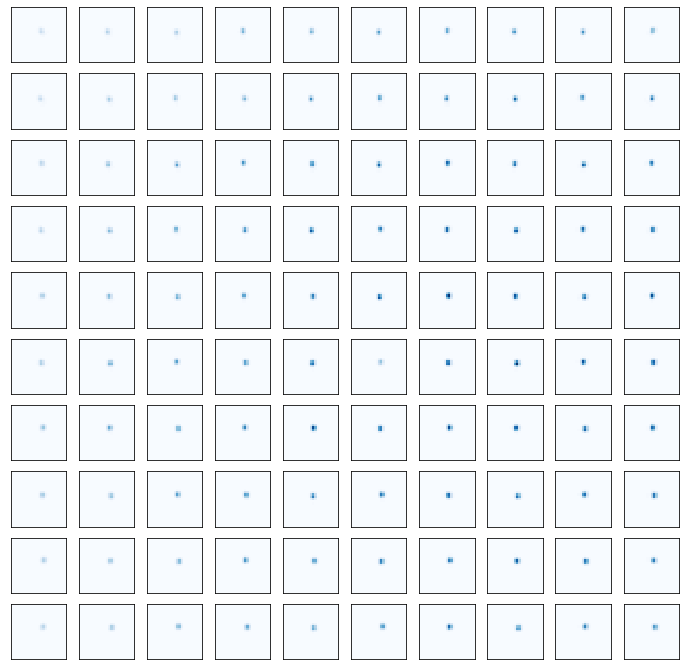

In [24]:
subimages = analysis.take(img, vectors=square, size=25)
analysis.take_plot(subimages)                   # The plotting for this takes a bit.

The spots are a few pixels off in a few places, but a bigger issue is the uniformity. We can get a histogram of the spot powers with another helper function `image_normalization()`.

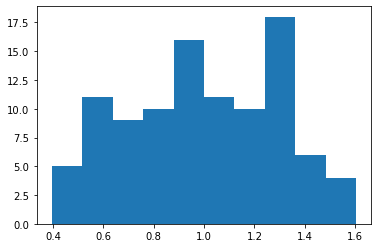

In [25]:
powers = analysis.image_normalization(subimages)
plt.hist(powers / np.mean(powers))
plt.show()

There's a 60% variation across the array, largely from diffraction inefficiency closer to the field of view. This isn't surprising, as we're filling our camera with spots, and this area corresponds to nearly the full $k$-space of the SLM. In practice, the closer to the edge of the $k$-space one gets, the lower the efficiency due to sampling considerations. Fortunately, `slmsuite` is a package that considers the unification of SLMs and cameras, so we have a solution.

#### A Uniform Square Array

That solution is camera feedback. We can easily enable this by using the option to `feedback` upon the power at spots measured by the camera. This is enabled with the `"experimental_spot"` option. We precondition our optimization with a pattern optimized computationally, without experimental feedback. The optimization with experimental feedback is a bit slower because we wait for the SLM to settle and for the camera to grab an image.

In [26]:
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=square, basis='ij', cameraslm=fs)

hologram.optimize('WGS-Kim', maxiter=40, feedback='computational',     stat_groups=['computational'])
hologram.optimize('WGS-Kim', maxiter=20, feedback='experimental_spot', stat_groups=['computational', 'experimental_spot'])

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


And let's take a look at our result.

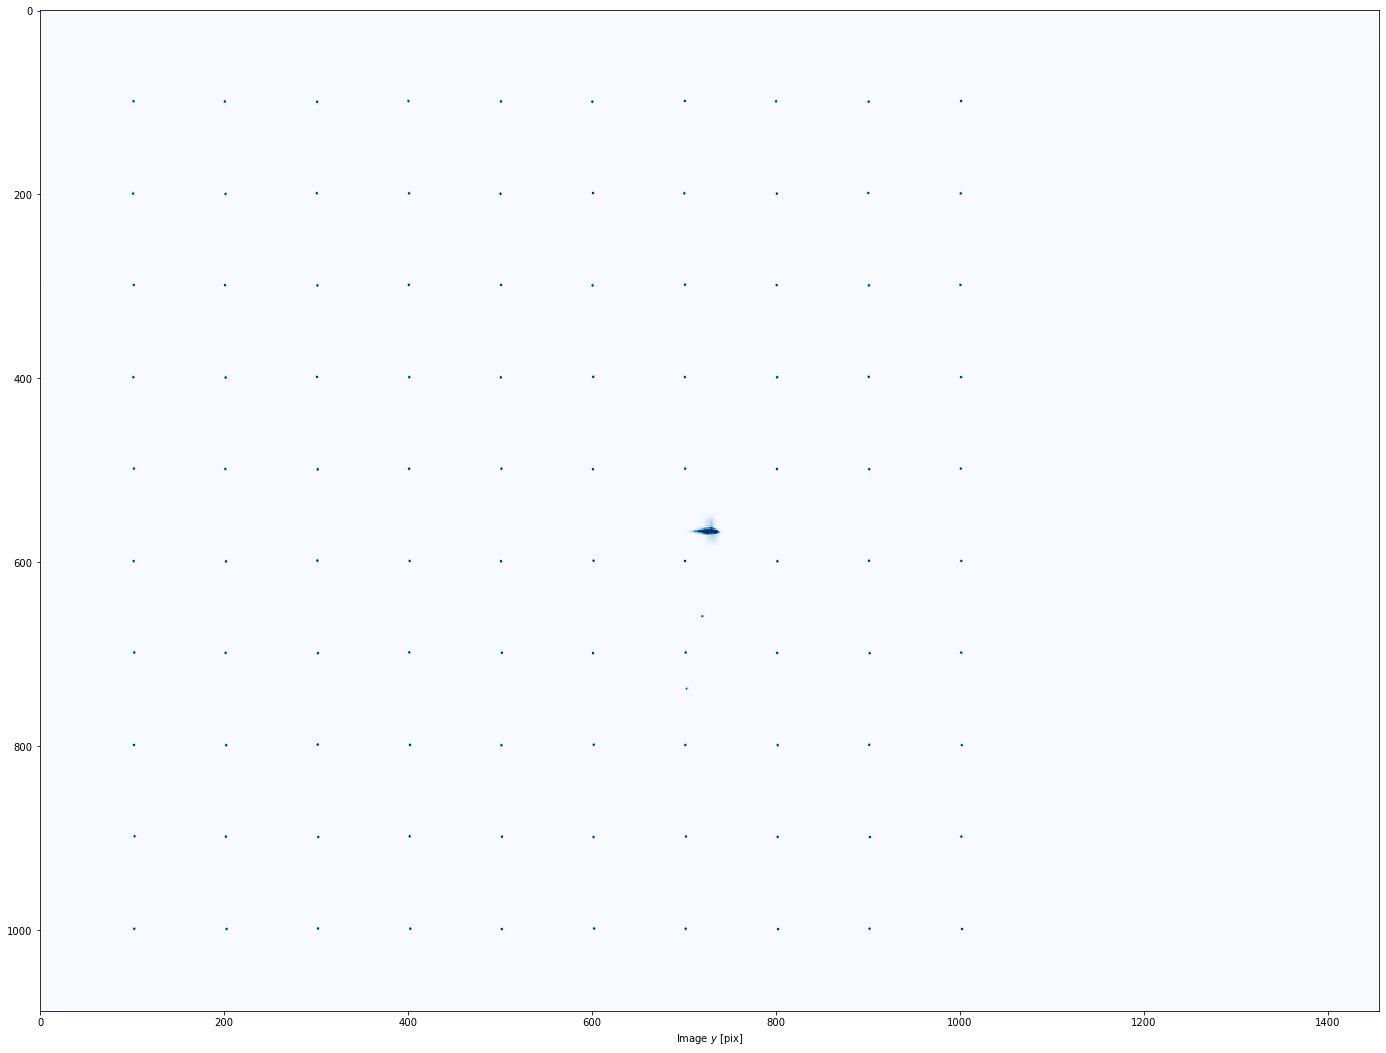

In [27]:
img = fs.cam.get_image()                                        # Grab image (this time we dont' have to .write() to the SLM, because the optimization did this already).

plt.figure(figsize=(24,24));    plt.imshow(img, vmax=50)        # This is saturated for visibility.
plt.xlabel("Image $x$ [pix]");  plt.xlabel("Image $y$ [pix]")
plt.show()

This looks more uniform, but it's hard to tell from the saturation. Let's take another look at the statistics of our array.

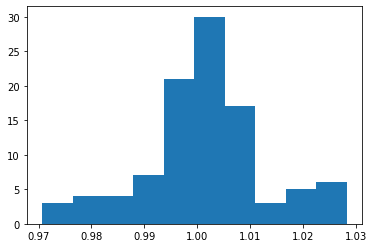

In [28]:
subimages = analysis.take(img, square, 25)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
plt.hist(power / np.mean(power)); plt.show()

Much more uniform. With the `stat_groups` parameter, we also asked the `SpotHologram` to note statistics as the optimization proceeded. We can plot these with the `.plot_stats()` function.

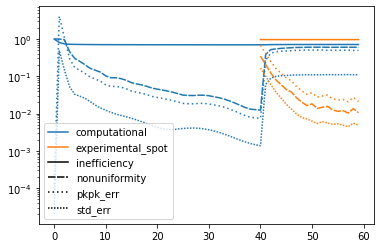

In [29]:
hologram.plot_stats()

This begs the question of what limits uniformity. In the case of this setup, it's likely the precision of our camera and the fact that power is concentrated on only a few of these 8-bit pixels.

#### A Scattered Example

[Lloyd's Algorithm](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) iteratively generates an array of spots spread across a given space. In this case, we want to generate a cloud of points within the field of view of our camera.

In [30]:
lloyds_points = toolbox.lloyds_points(grid=tuple(int(s/5) for s in fs.cam.shape), n_points=100, iterations=40) * 5

The `/5` and `*5` are for faster generation at the cost of rounding to every 5th pixel. Let's take a look at what we generated.

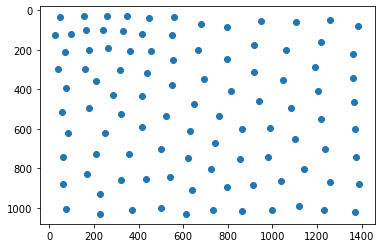

In [31]:
plt.scatter(lloyds_points[0, :], lloyds_points[1, :])
plt.gca().set_ylim(np.flip(plt.gca().get_ylim()))
plt.show()

We conduct the same process to optimize a hologram to generate this pattern.

In [32]:
hologram = SpotHologram((2048, 2048), lloyds_points, basis='ij', cameraslm=fs); cam.set_exposure(.0005)

hologram.optimize('WGS-Kim', maxiter=20, feedback='computational',     stat_groups=['computational'])
hologram.optimize('WGS-Kim', maxiter=10, feedback='experimental_spot', stat_groups=['computational', 'experimental_spot'])

100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Let's again take a look at what we generated.

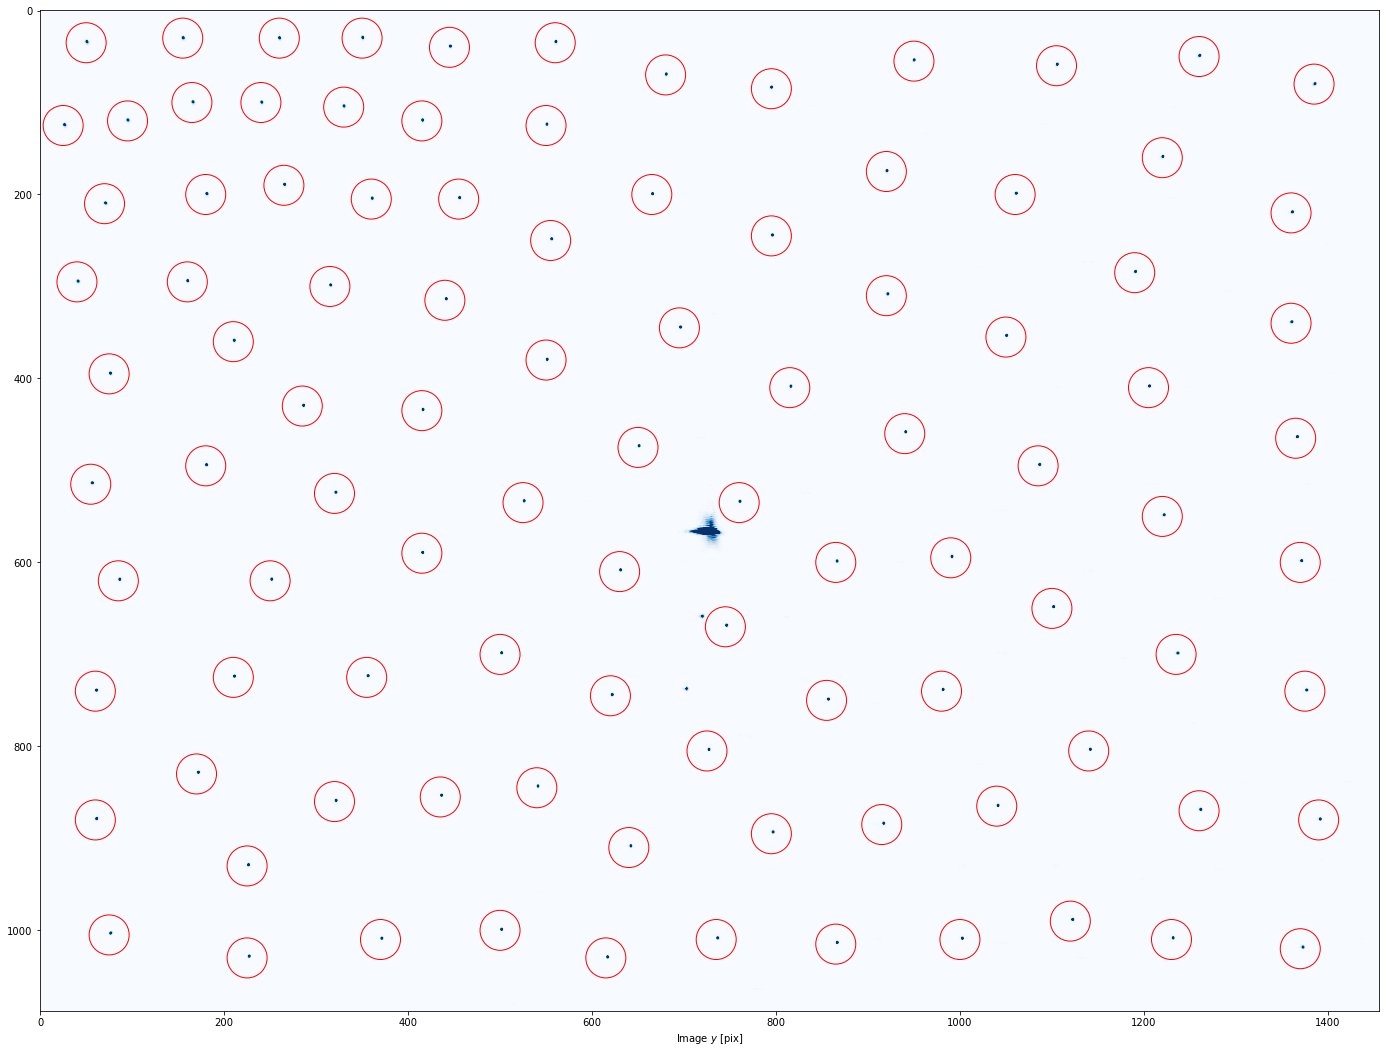

In [33]:
img = fs.cam.get_image()

plt.figure(figsize=(24,24))
plt.imshow(img, vmax=50)
plt.xlabel("Image $x$ [pix]"); plt.xlabel("Image $y$ [pix]")
plt.scatter(lloyds_points[0, :], lloyds_points[1, :], 1600, facecolors='none', edgecolors='r')
plt.show()

Let's again take a look at the statistics. The optimization was faster, as expected for a pattern with less crystallinity.

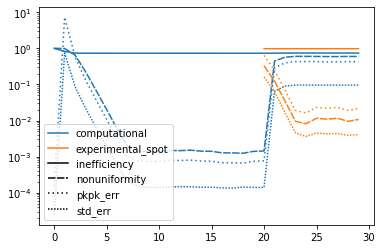

In [34]:
hologram.plot_stats()

### Pictorial Holography

The spot holography we explored above is a subset of the general problem. In this section, we push further and look into forming images at desired positions in the camera's domain.

Let's start by loading a picture. We write an example helper function for this.

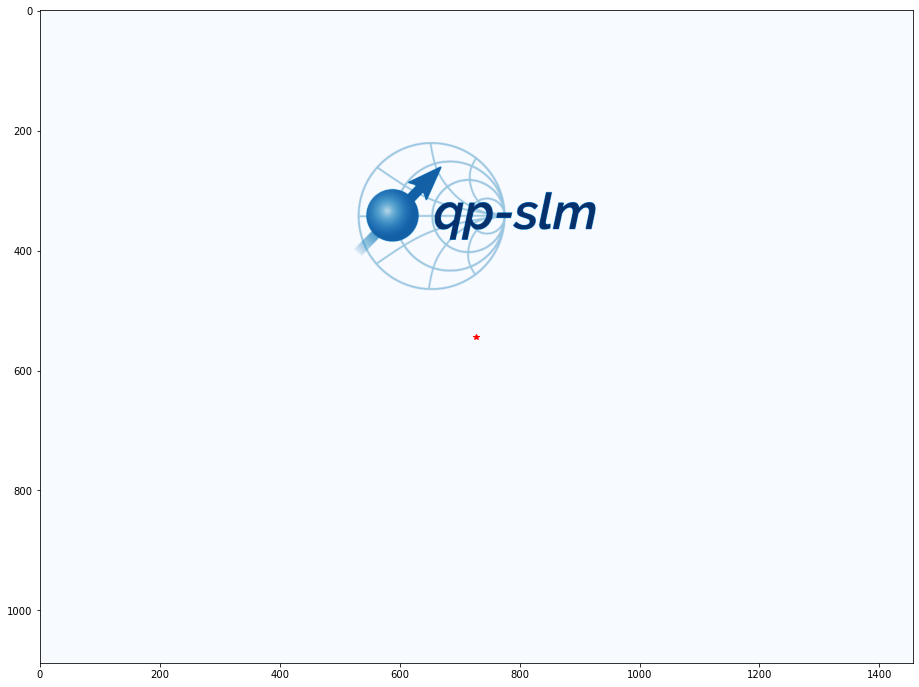

In [211]:
path = os.path.join(os.getcwd(), '../../source/static/qp-slm-small.png')

def load_img(path, target_shape=None, angle=0, shift=(-200, 0), plot=False):
    # Load the image.
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("Image not found at path '{}'".format(path))

    # Invert if necessary such that the majority of the image is dark.
    if np.mean(img) > np.mean(cv2.bitwise_not(img)):
        img = cv2.bitwise_not(img)

    if angle != 0:
        img = ndimage.rotate(img, angle)

    if target_shape is not None:
        zoom_x = target_shape[0] / img.shape[0]
        zoom_y = target_shape[1] / img.shape[1]
        img = ndimage.zoom(img, min(zoom_x, zoom_y))

    # sqrt to get the amplitude.
    target_ij = toolbox.pad(analysis._make_8bit(np.sqrt(img)), fs.cam.shape)

    # Shift to the desired center.
    target_ij = np.roll(target_ij, shift, axis=(0,1))

    if plot:
        plot_img(target_ij)
        plt.show()

    return target_ij

def plot_img(target_ij):
    # Plot the desired camera space.
    plt.figure(figsize=(16,12))
    plt.imshow(target_ij)
    plt.plot(target_ij.shape[1]/2, target_ij.shape[0]/2, 'r*')

target_ij = load_img(path, plot=True);

Notice that the resulting image has the same shape as the camera. The goal is to replicate this pattern on the camera at the same position. We use similar syntax as before to initialize and optimize the hologram. This time we use a `FeedbackHologram`, which is actually the superclass of `SpotHologram`. `FeedbackHologram` is a subclass of `Hologram`, a class that only considers the abstract. `FeedbackHologram` has infrastructure to read in and interpret camera images. `SpotHologram` has infrastructure honed to optimize spot arrays. Let's take a look at our `FeedbackHologram`.

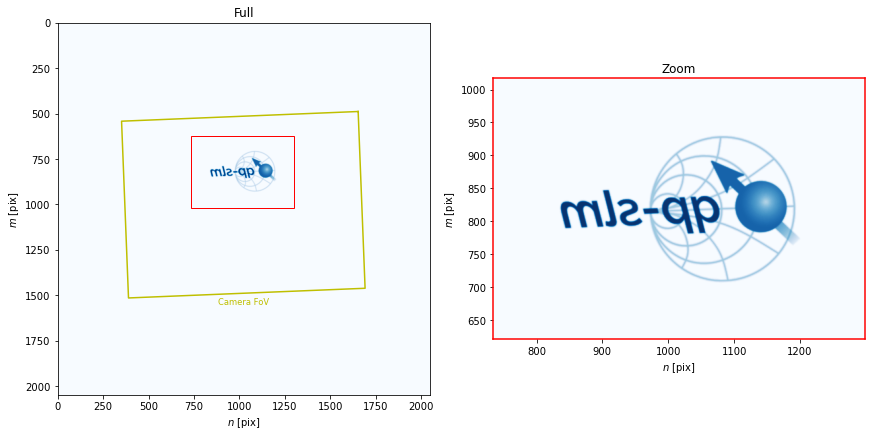

In [222]:
hologram = FeedbackHologram(shape=(2048, 2048), target_ij=target_ij, cameraslm=fs);
limits = hologram.plot_farfield(hologram.target); fs.cam.set_exposure(.005)

We see how the image is imprinted upon the `"knm"` space in which the hologram is optimized. Now let's optimze it.

In [223]:
hologram.optimize(method="WGS-Kim", maxiter=50, feedback='computational', stat_groups=['computational'])

100%|██████████| 50/50 [00:01<00:00, 44.92it/s]


We quickly plot the image, and see our hologram! It looks alright. There's a little notch out of the 'm', perhaps due to some dust.

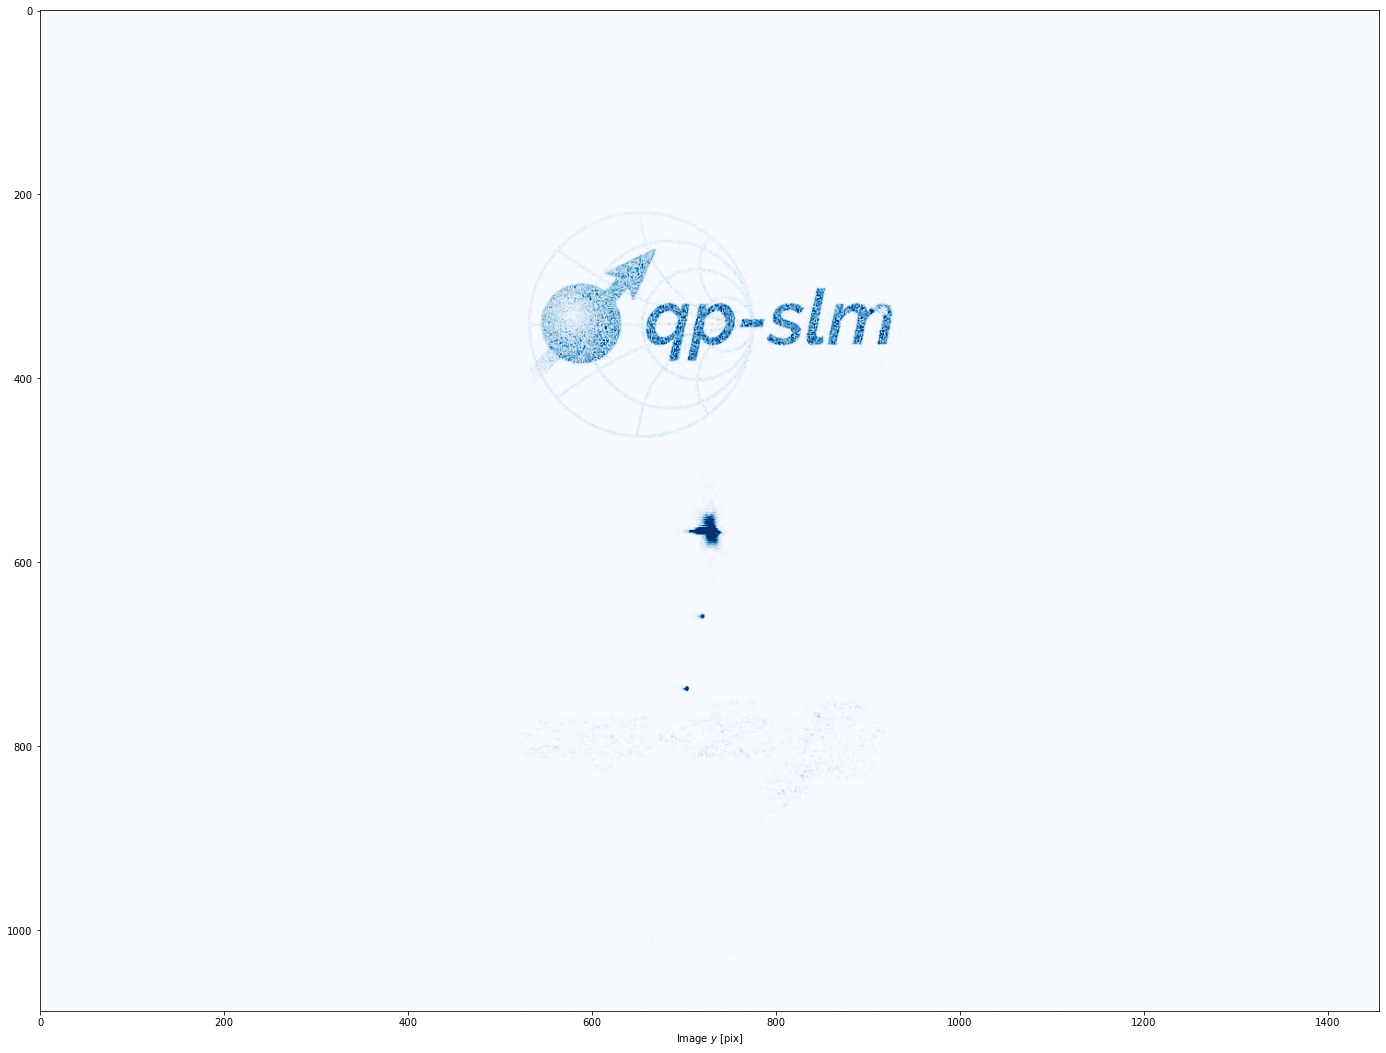

In [224]:
fs.slm.write(hologram.extract_phase(), settle=True)
fs.cam.set_exposure(.008)
img = fs.cam.get_image()

plt.figure(figsize=(24,24))
plt.imshow(img)
plt.xlabel("Image $x$ [pix]"); plt.xlabel("Image $y$ [pix]")
plt.show()

This is the phase that produces that result.

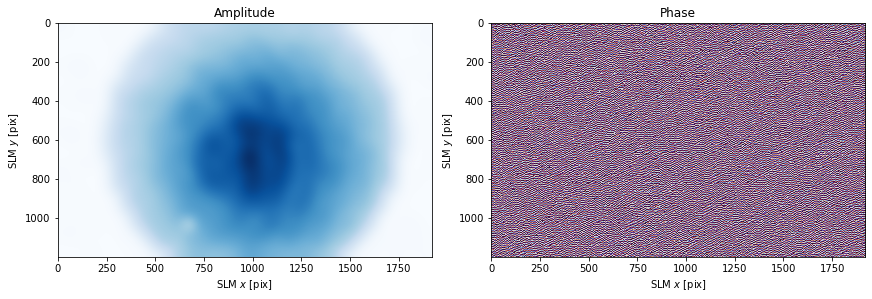

In [225]:
hologram.plot_nearfield()

We can also take a look at the hologram computationally, i.e. the expected result from Fourier-transforming the nearfield. Notice that there is some power in the field, and we need to use the `limits` from the previous `.plot_farfield()` to get the zoom box to not be the whole domain.

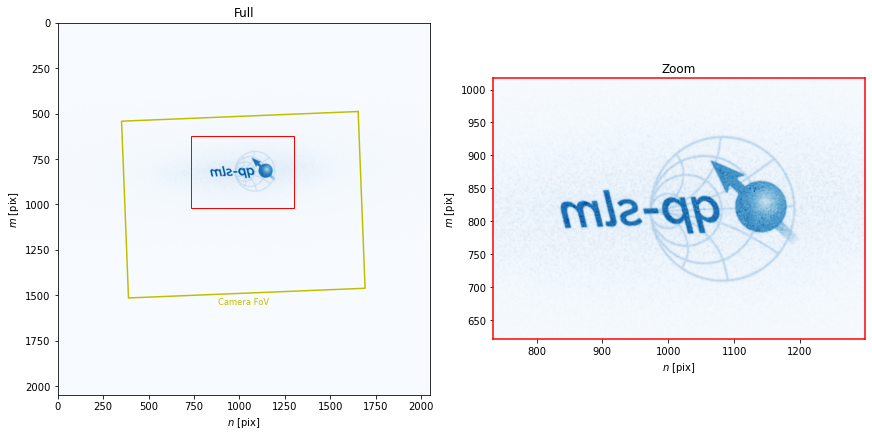

In [228]:
hologram.plot_farfield(np.abs(hologram.extract_farfield()), limits=limits);

We can push this a bit further by again applying camera feedback, this time to the whole image.

In [229]:
hologram.optimize(method="WGS-Kim", maxiter=10, feedback='experimental', stat_groups=['computational', 'experimental'], blur_ij=.5)

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


This doesn't work super well at the moment due to speckle, which we attribute to non-uniform farfield phase, but the m if filled in again and the whole hologram appears with higher fidelity.

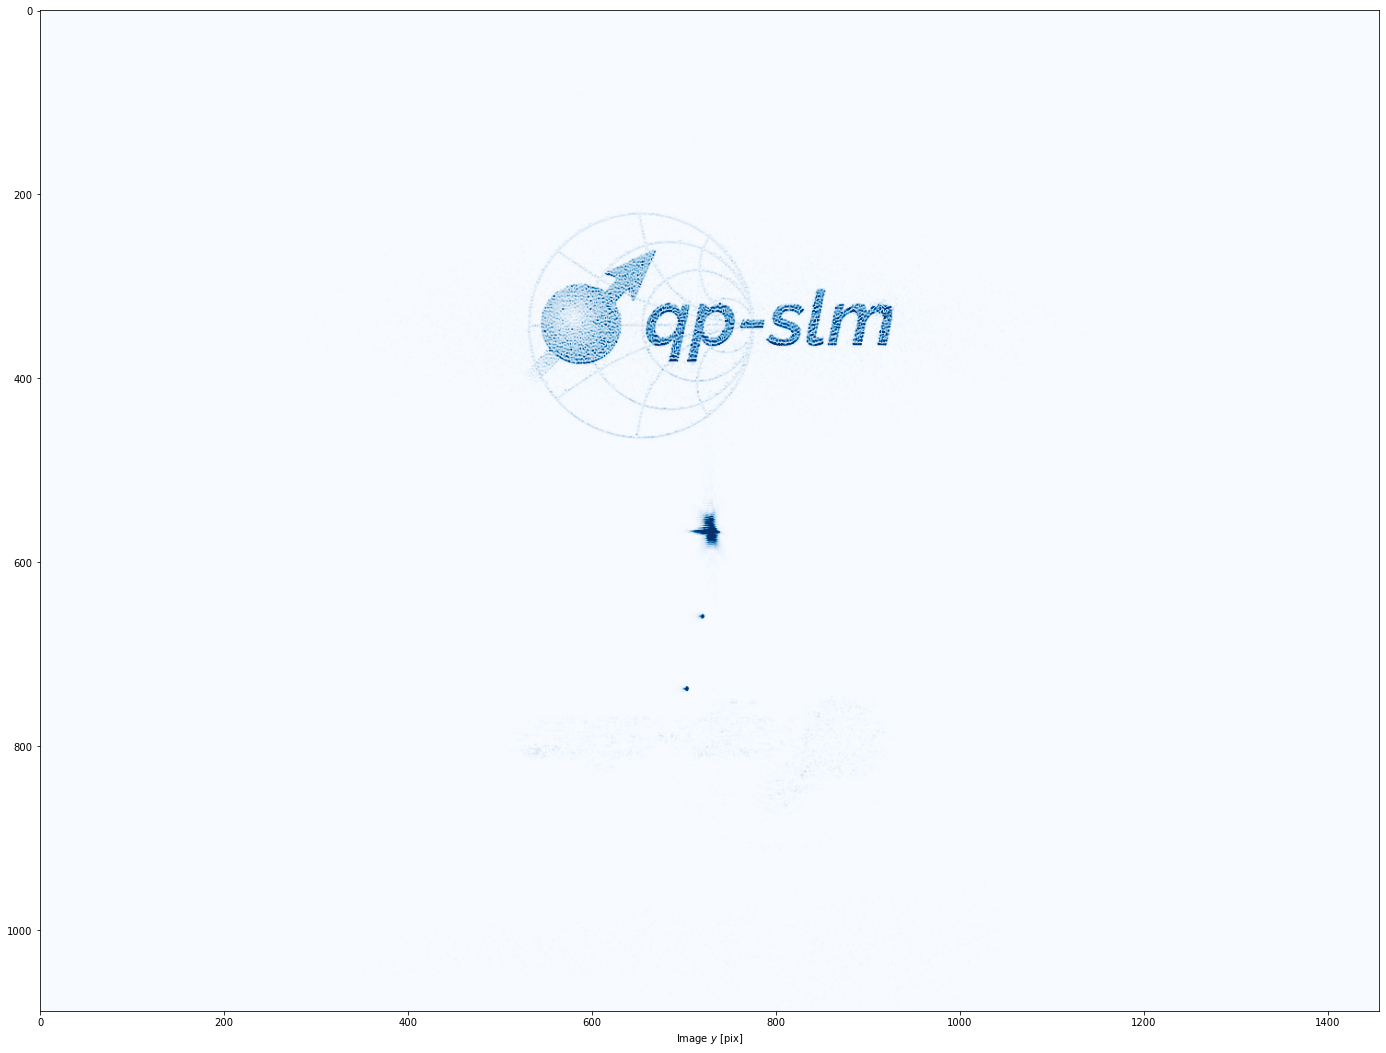

In [230]:
fs.slm.write(hologram.extract_phase(), settle=True)
fs.cam.set_exposure(.008)
img = fs.cam.get_image()

plt.figure(figsize=(24,24))
plt.imshow(img)
plt.xlabel("Image $x$ [pix]"); plt.xlabel("Image $y$ [pix]")
plt.show()

We look forward to seeing what sort of holograms you'll make!